<a href="https://colab.research.google.com/github/JDM-ULL-93/Practica_TID/blob/master/Clustering_Jerarquico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indice

[Volver al indice](https://colab.research.google.com/github/JDM-ULL-93/Practica_TID/blob/master/Indice.ipynb)

# **Paquetes necesarios**

*   **caret:** contiene funciones para entrenar y dibujar modelos de clasificación y regresión. Aunque para este modelo, solo lo usaremos para un balanceo  con **upSample**
*   **dplyr:** contiene funciones para la manipulación de datos tales como filtrado por filas, selección de columnas, reordenación de filas ...

















In [0]:
if (!requireNamespace("caret"))
  install.packages("caret")
library(caret)
if (!requireNamespace("dplyr"))
  install.packages("dplyr")
library(dplyr)

Loading required namespace: caret

Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Carga y visualización de datos

Cargamos nuestro datasheet a memoria.Nuestro datasheet corresponde a un conjunto de datos normalizados y preprocesados (detección de valores nulos, eliminación parcial de outliers, analisis de componentes principales)  respecto al original. 

Nuestra base de datos se basa en las mediciones realizadas por 8 sensores sobre 8 músculos con una frecuencia de 200Hz , estas mediciones se hicieron 6 veces durante 20 segundos para cada gesto, por lo tanto:
* Tenemos un total de 64 columnas, cada una para cada sensor que mide cada musculo en cada movimiento, todas ellas de tipo float con valores dentro del rango **[-128.0,127.0]**. 
* Cada *487* filas corresponden a una de las 6 mediciones realizadas por 20 segundos para cada gesto. Este medición se hizo, de principio a fin,haciendo el mismo gesto, en una posición fija, sin transiciones de ningún tipo.
* Una última columna que representa el tipo de gesto al que se corresponde la medición:
```c#
Enum {
  Roca = 0,
  Tijeras = 1,
  Papel = 2,
  Ok = 3
}
```

El objetivo de nuestro tratamiento de datos es, con todas las variables de las que disponemos (excluyendo la clase) predecir el tipo de gesto que se ha realizado.

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1.42838349,0.40170696,1.15012947,1.1730891,-0.04710804,-0.48219055,-4.293642,-4.24028809,-0.45983856,0.22415026,⋯,-1.7855609,3.3968017,0.39488063,1.7644141,0.7726201,0.2324183,-0.2592921,-2.2783569,1.0694782,0
2,-2.50338498,-0.44813614,-0.85390090,-0.8425861,0.73718804,-0.01724597,1.445703,-0.60602378,0.58850359,-0.28255256,⋯,-1.5876586,2.6277596,0.56147502,1.3619800,0.7726201,0.7368608,0.8365519,4.4517214,1.0050871,0
3,-0.99530940,-0.61810475,-1.45511001,-0.9769644,-1.16753100,-0.21097288,-3.097945,0.82172292,0.03674456,0.47750168,⋯,-5.4137702,0.4304965,0.64477221,0.3558947,-0.9878456,0.4005658,0.8365519,4.5704875,3.1299941,0
4,0.13574728,0.31672265,0.14811428,0.3668191,0.00891311,0.87389779,4.275519,-0.86561409,-0.84606988,-0.11365162,⋯,-2.4452353,-0.5582719,0.39488063,1.5631970,1.5851427,1.8578441,1.5410231,4.7684310,2.8080385,0
5,0.35118665,0.06176972,0.14811428,-0.1706943,-0.77538297,0.40895322,-1.981961,0.36743988,0.42297588,0.05524932,⋯,2.5682902,-1.8766298,-0.60468571,0.5571117,0.9080405,-0.7204175,-0.9246259,-4.3765578,-4.4037671,0
6,0.83592523,-0.36315183,-0.85390090,-1.9176128,0.68116689,-0.83089898,-1.463826,2.37926477,0.53332768,0.56195215,⋯,-1.6536260,0.3206333,0.56147502,1.3619800,1.5851427,0.2884675,1.1887875,-1.8428813,1.6489983,0
7,-0.61829051,-0.36315183,-0.05228875,0.6355757,-0.88742526,-0.63717207,-2.699379,-0.99540924,-0.62536627,-0.19810209,⋯,0.1274949,-1.9315614,-0.77128010,-2.2599270,-2.0712090,-0.6643683,-1.8247835,0.2949083,-1.8925134,0
8,2.34400081,0.06176972,-0.25269179,0.9043324,0.62514574,1.02887931,2.083408,1.79518657,-0.45983856,-0.11365162,⋯,2.7661925,0.8699491,0.39488063,2.1668482,3.4810288,0.5126641,0.5234537,2.9473510,3.0656030,0
9,-1.80320704,0.31672265,1.95174161,3.9950344,0.34504000,-0.94713512,-4.891490,-0.02194558,0.69885539,-0.45145350,⋯,-0.3342772,2.2981702,0.06169185,-1.8574929,-2.2066295,1.1852541,0.1320808,1.7201014,0.7475226,0


       V1                  V2                 V3                  V4          
 Min.   :-5.411816   Min.   :-8.77660   Min.   :-6.465186   Min.   :-8.63653  
 1st Qu.:-0.456711   1st Qu.:-0.27817   1st Qu.:-0.453095   1st Qu.:-0.43945  
 Median :-0.025832   Median :-0.02321   Median :-0.052289   Median :-0.03632  
 Mean   :-0.000584   Mean   :-0.00182   Mean   : 0.005197   Mean   : 0.01625  
 3rd Qu.: 0.351187   3rd Qu.: 0.31672   3rd Qu.: 0.548920   3rd Qu.: 0.36682  
 Max.   : 6.006470   Max.   : 7.28544   Max.   : 6.160205   Max.   : 5.74195  
       V5                  V6                 V7                 V8          
 Min.   :-5.593202   Min.   :-4.39547   Min.   :-5.05092   Min.   :-8.26394  
 1st Qu.:-0.551298   1st Qu.:-0.52094   1st Qu.:-0.14856   1st Qu.:-0.41133  
 Median : 0.008913   Median :-0.01725   Median : 0.01087   Median :-0.02195  
 Mean   :-0.002763   Mean   :-0.00144   Mean   : 0.01616   Mean   : 0.01074  
 3rd Qu.: 0.569125   3rd Qu.: 0.52519   3rd Qu.: 0.17029 

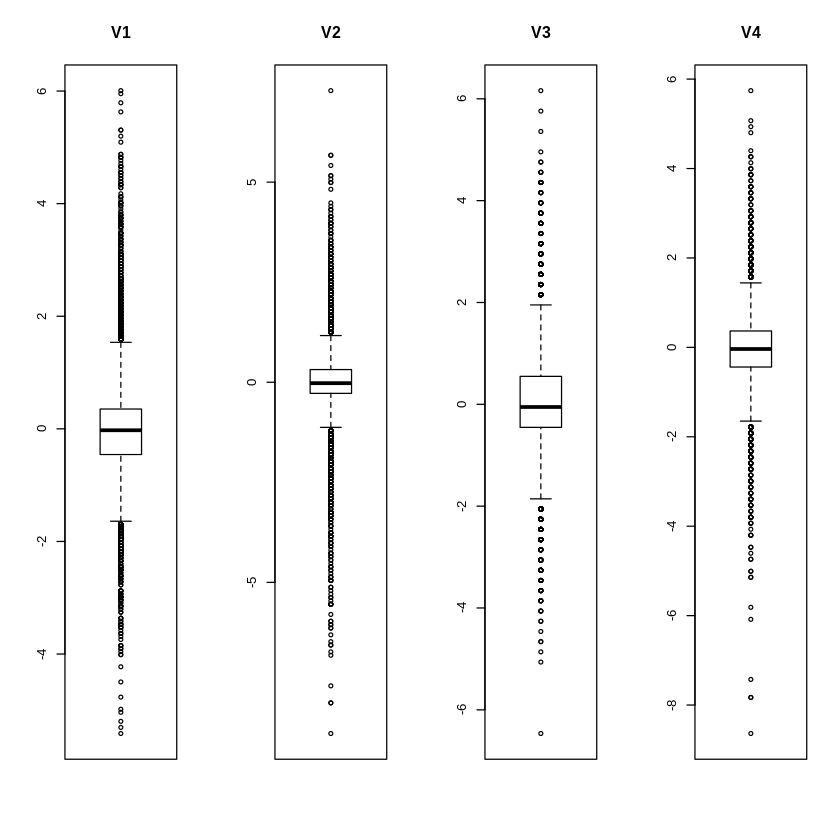

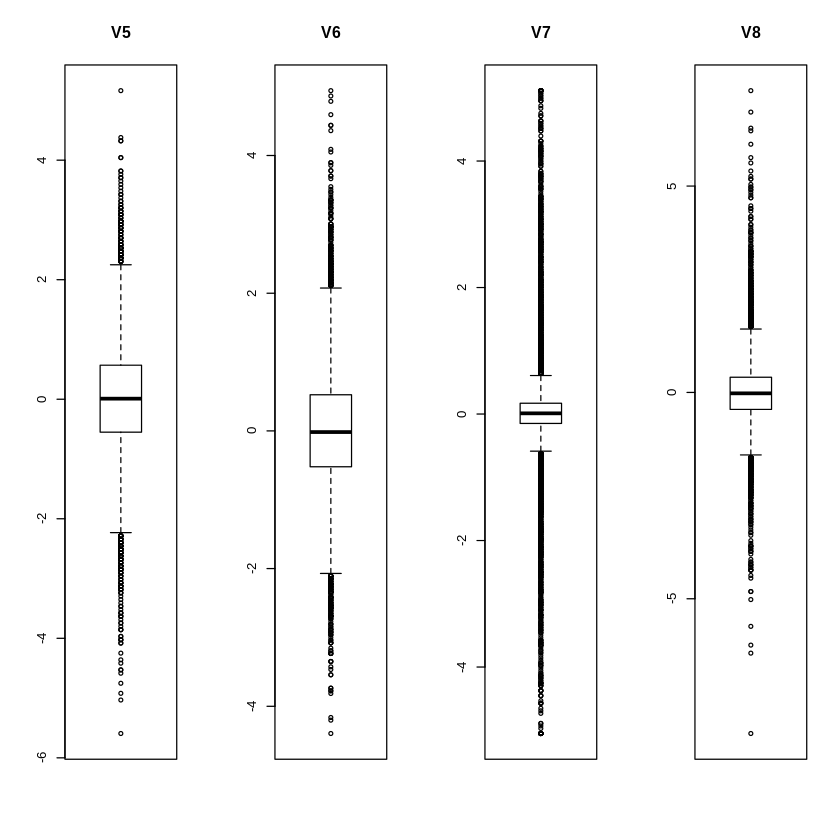

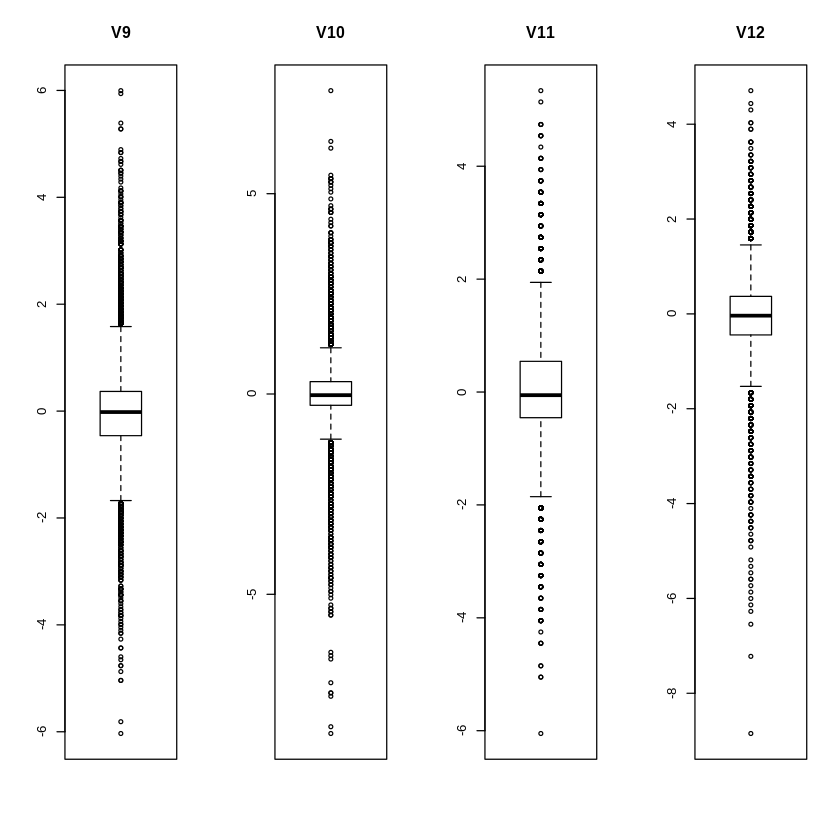

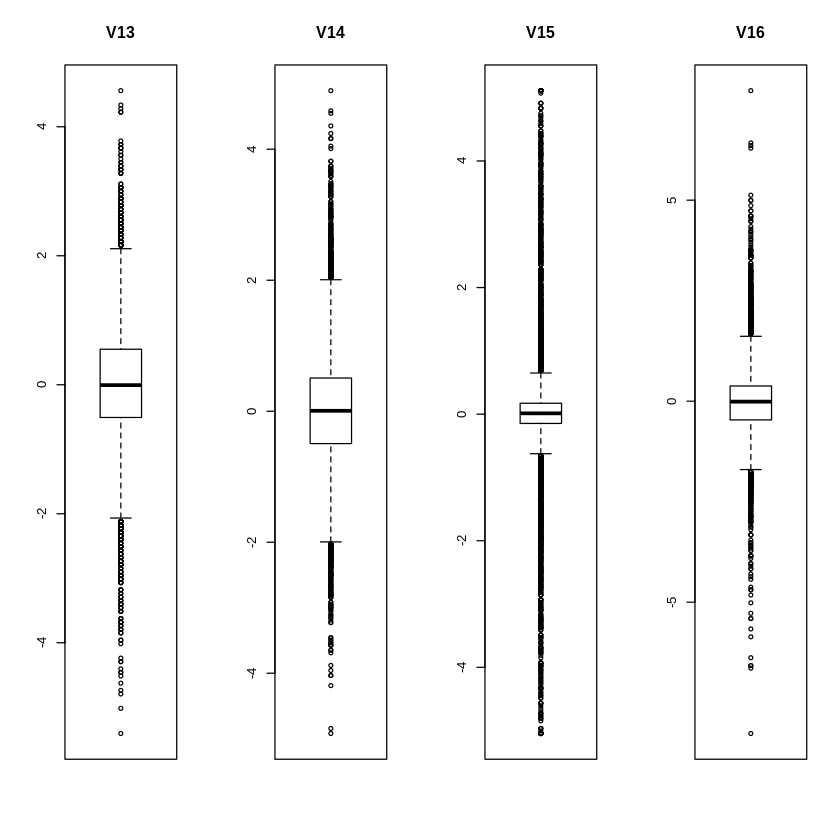

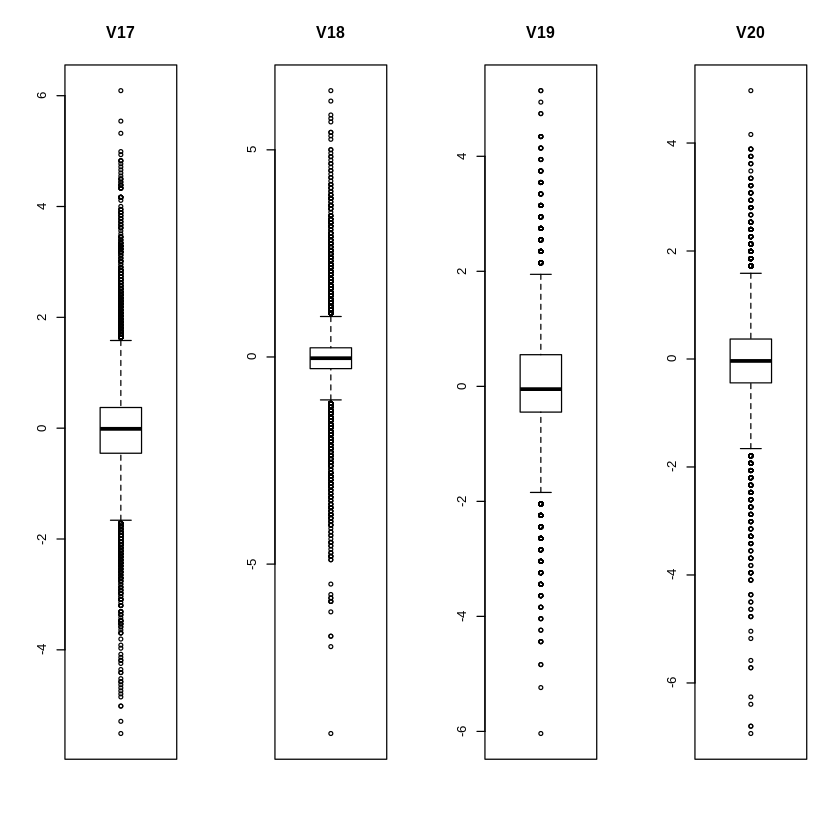

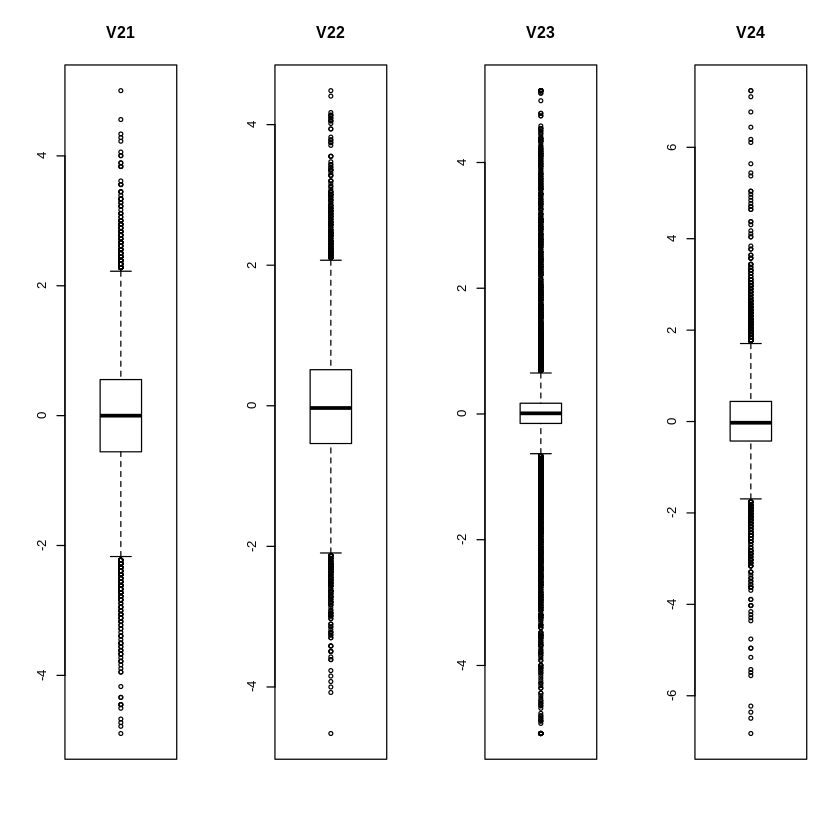

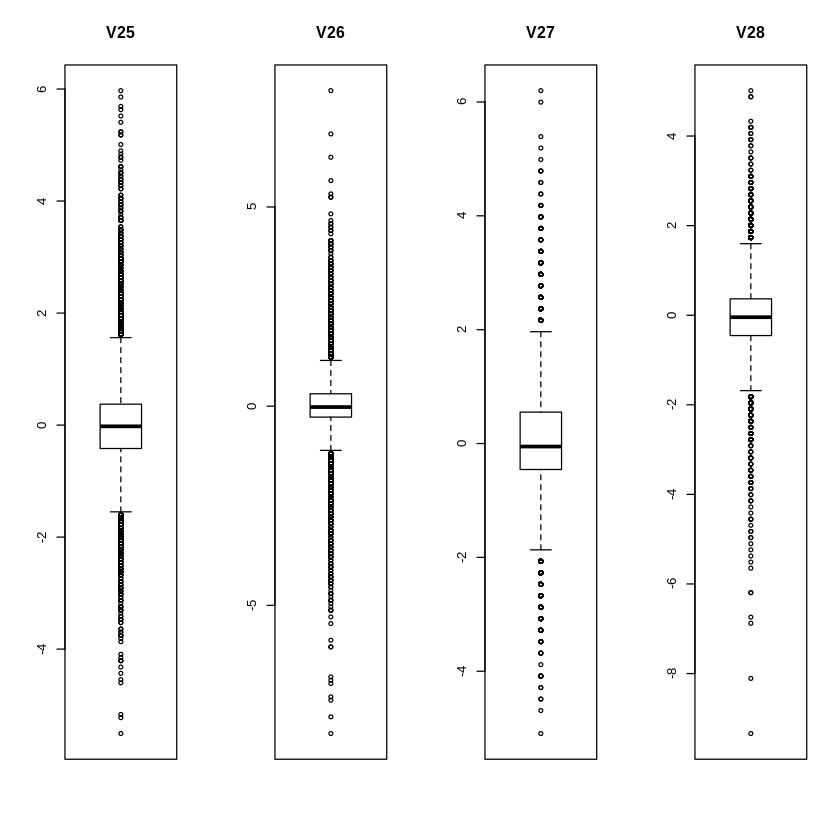

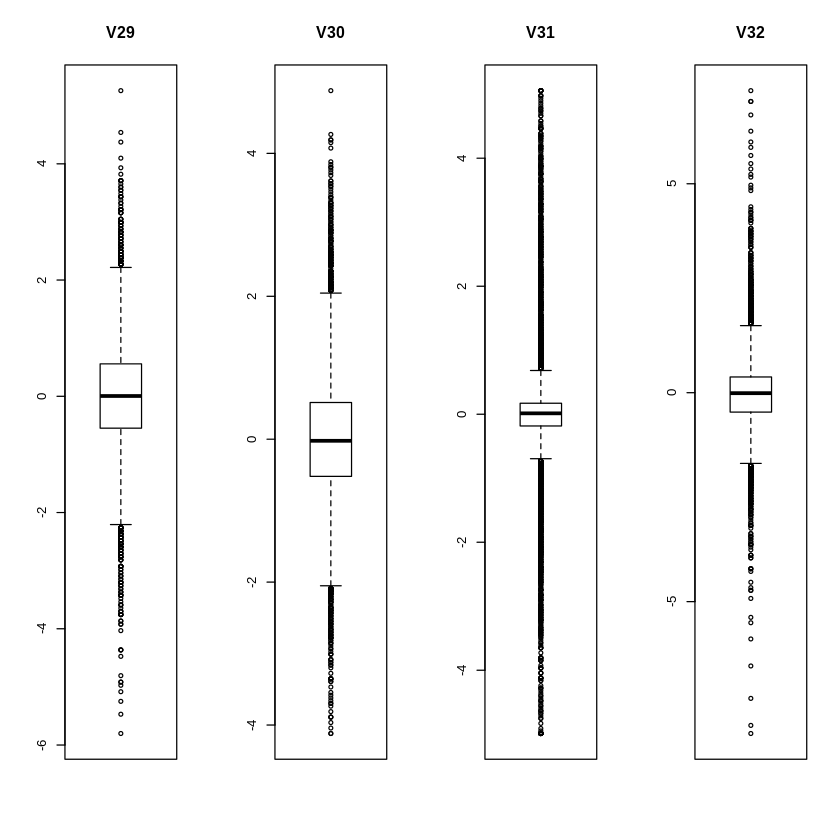

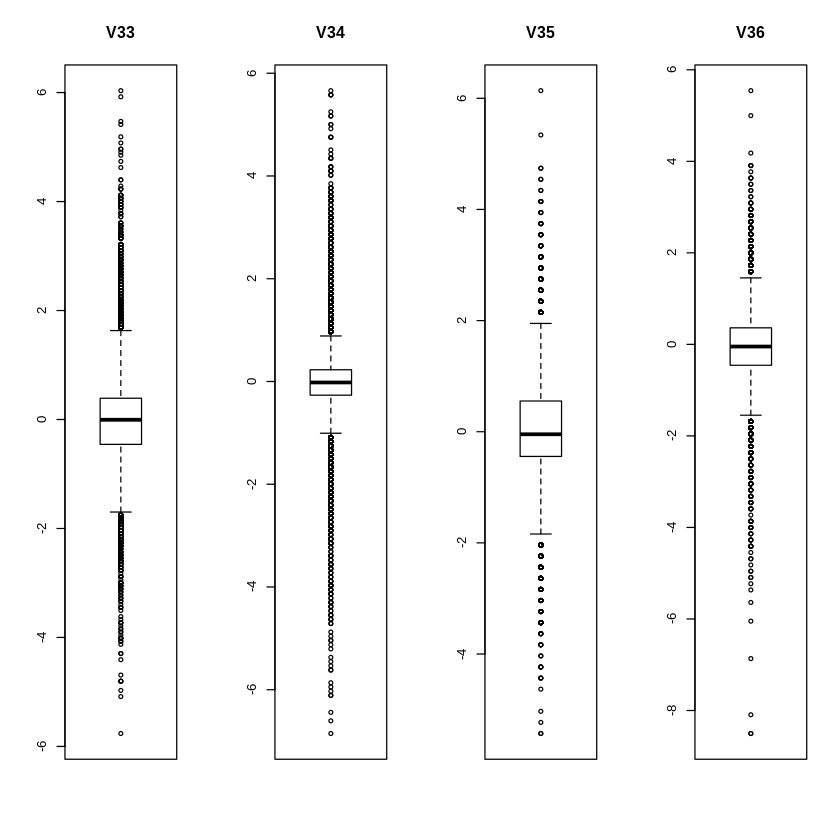

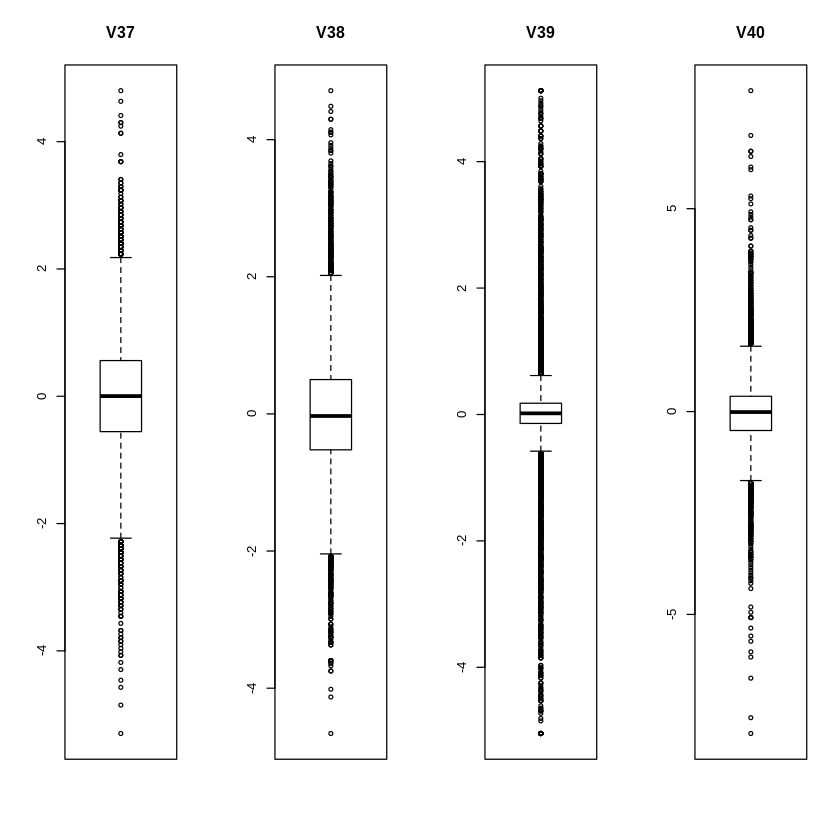

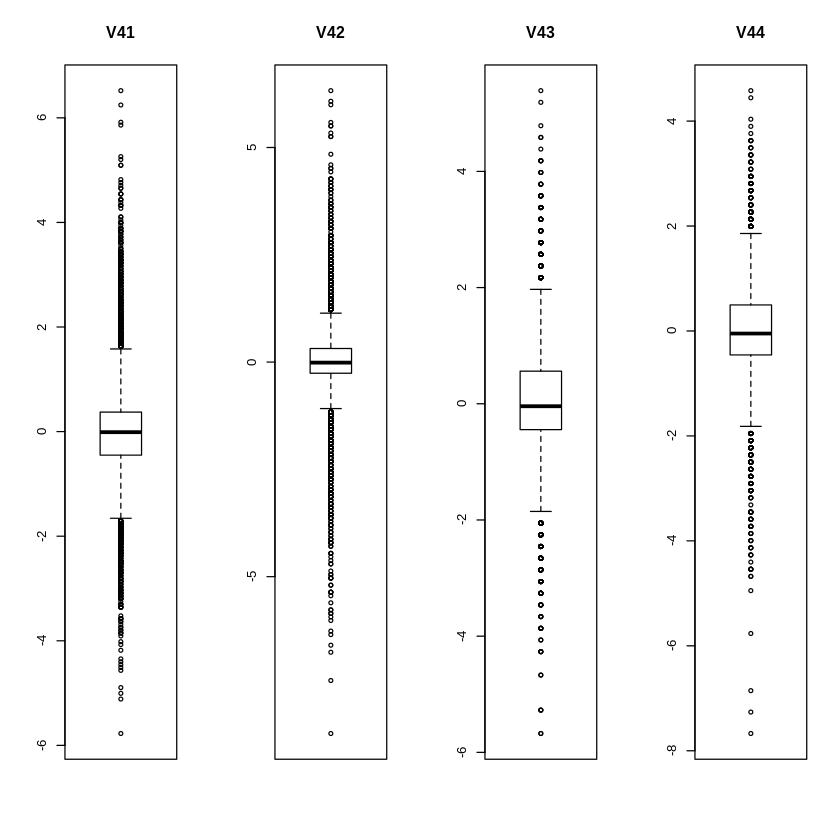

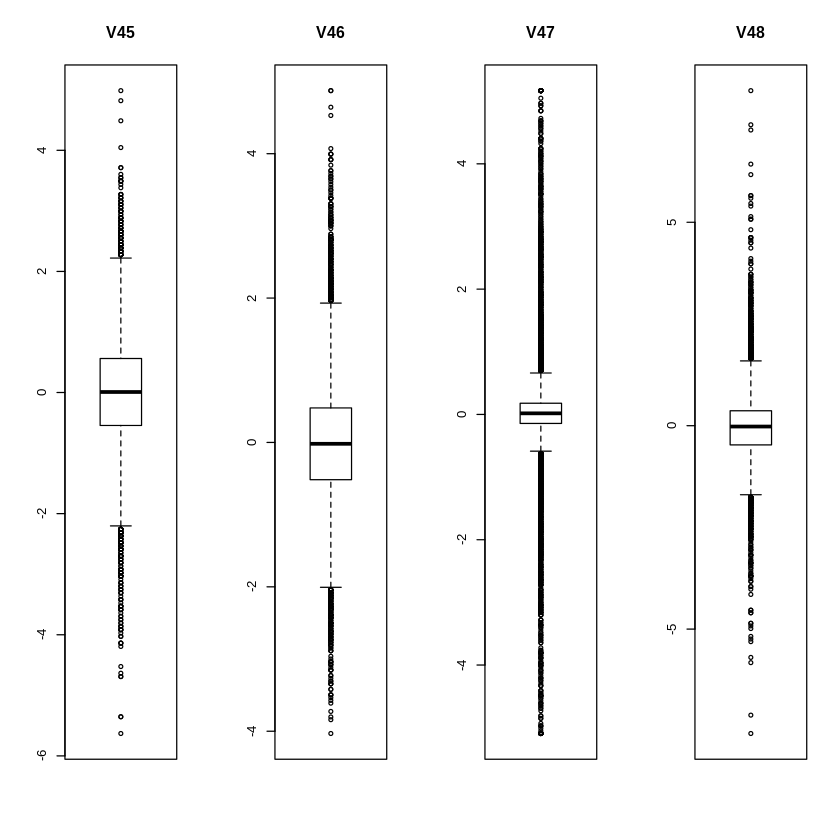

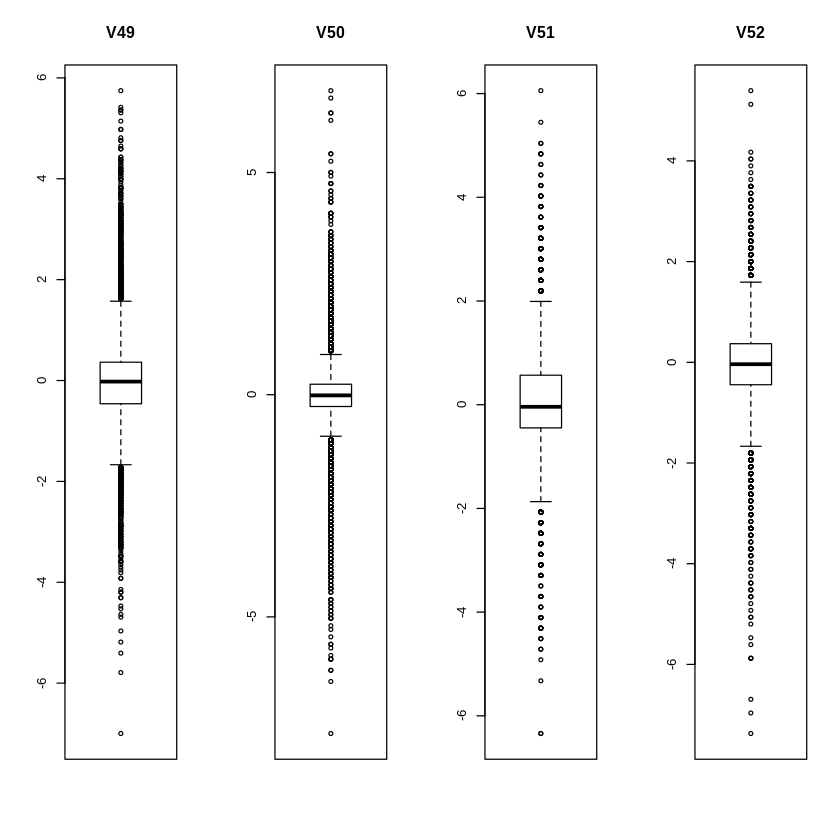

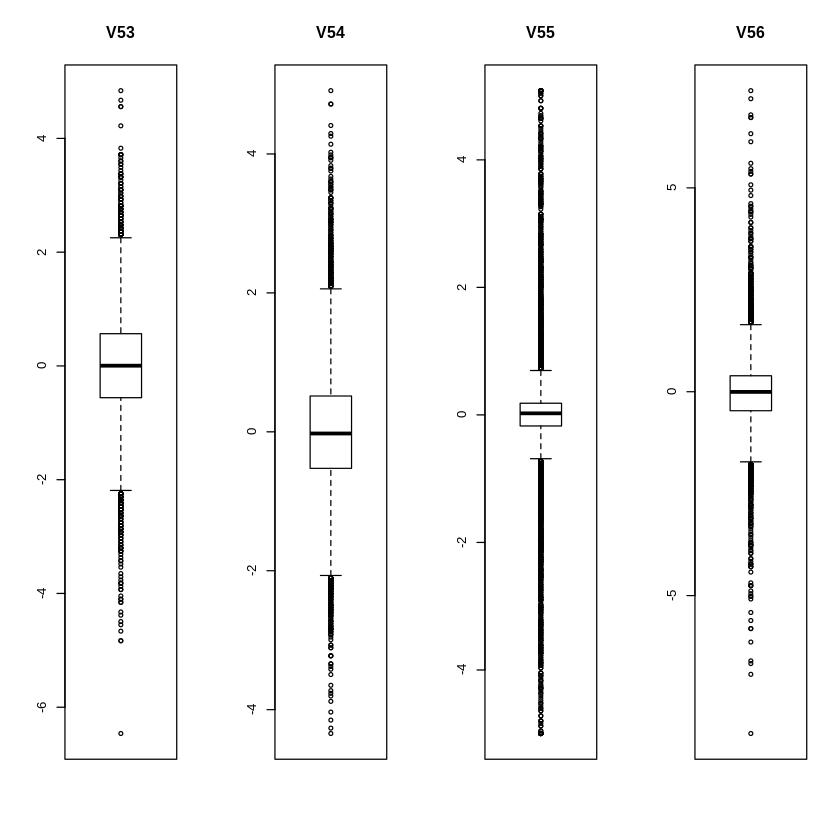

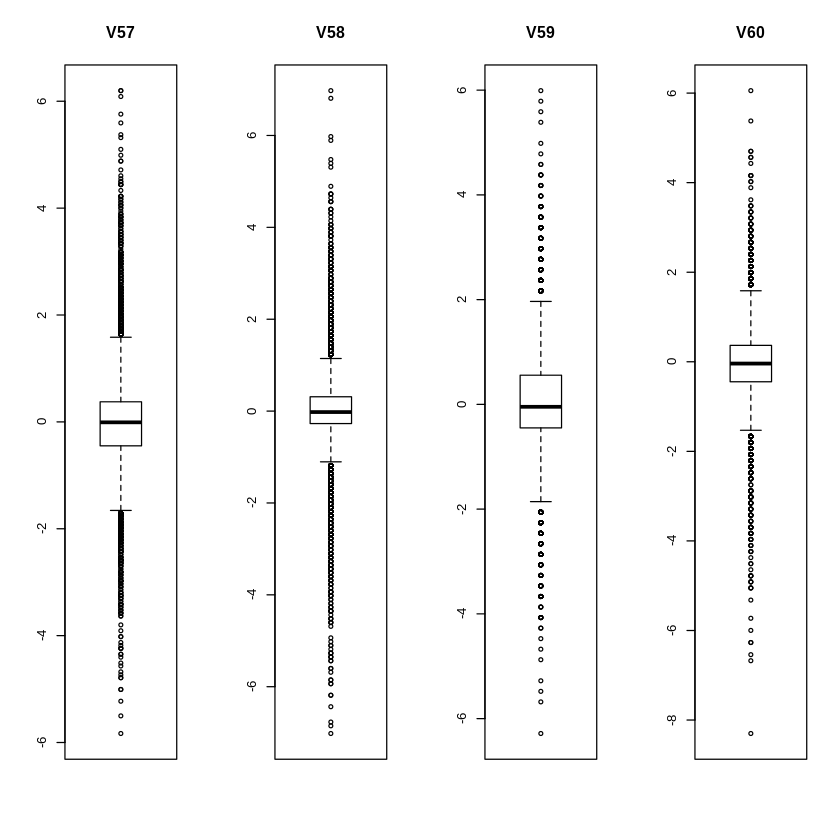

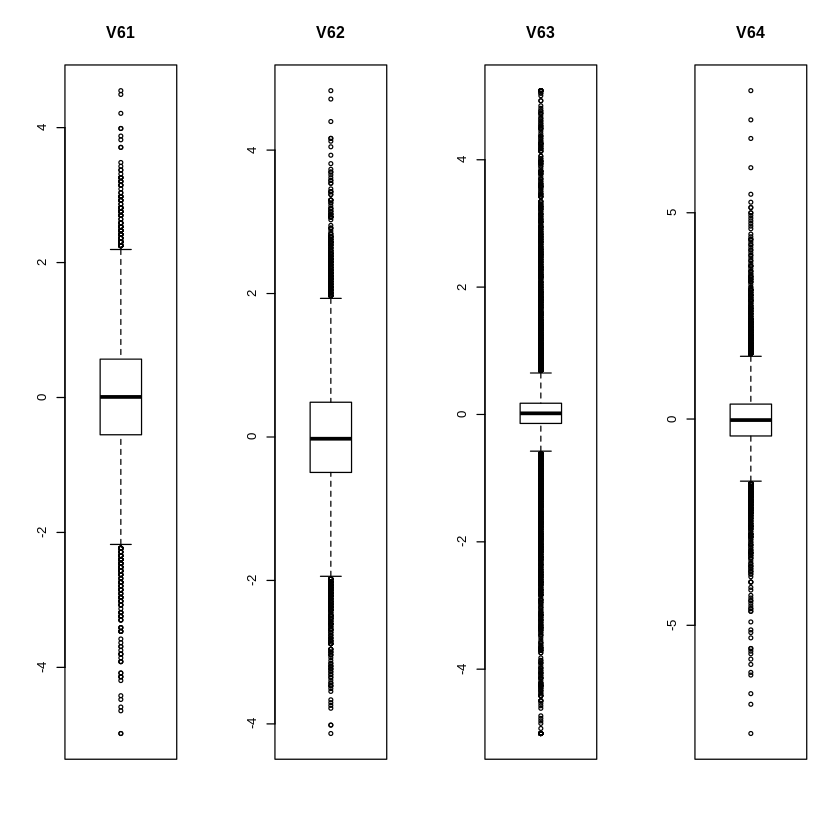

In [0]:
#Cargamos nuestros datos
#data = read.csv("/content/all.csv",header=FALSE, sep=",")
#data = read.csv("https://uc36943bfd09a58be3b54c0ce836.dl.dropboxusercontent.com/cd/0/get/A4R6OXi1GuzkFsDQE41Vj1vo8nvN3gCH8OnA41L9RZdmTUZZSz4sb7MCkkpfc1SyR9V27bcczlCjvpBJDLukItZXb1kPtwTT4PwGwNaCEL1i4ytv9tiHrGZSXI10waPGzIc/file#", header=FALSE, sep = ",")
data = read.csv("/content/cleanedAll.csv",header=FALSE, sep=",")
head(data, 10)

data$V65 <- as.factor(data$V65)
summary(data)

par(mfrow=c(1,4))
for(i in 1:64) {
  boxplot(data[,i], main=names(data)[i])
}


#Preprocesamiento de datos

Ya hicimos un preprocesado de datos , pero todavía faltaría dividir nuestros datos en 2 conjuntos, uno de entrenamiento y otro de validación, de forma que el primero sirva para crear el modelo y el segundo pueda servir para probar el modelo frente al mundo real, detectando la precisión del modelo o el posible sobreajuste de este.

In [0]:
set.seed(56)
data.entrenamiento <- sample_frac(data, 0.5) #Bajado de 0.7 a 0.5 para evitar sobreajustes
data.validacion <- setdiff(data, data.entrenamiento)

#Ejecutamos un upperSample en conjunto de entrenamiento para balancear clases
print("Antes de balanceo upperSample :")
summary(data.entrenamiento$V65)
data.entrenamiento <- upSample(data.entrenamiento, data.entrenamiento$V65)
print("Despues de balanceo upperSample :")
summary(data.entrenamiento$V65)




[1] "Antes de balanceo upperSample :"


0    1    2    3 
1315 1330 1389 1194

[1] "Despues de balanceo upperSample :"


0    1    2    3 
1389 1389 1389 1389

# Análisis. Obtención de Clustering Jerarquico

Para obtener el agrupamiento jerárquico podemos usar las funciones *hclust()* (del paquete stats) o *agnes()* (del paquete cluster). Las dos funciones tienen una sintaxis similar. Ambas requieren la matriz de distancias entre los puntos y el método a usar para unir los clusters. Obtendremos un agrupamiento jerárquico con cada función.

Entre los métodos disponibles para las funciones *hclust()* y *agnes()* se encuentran "*single*", "*complete*" y "*average*". La función *hclust()* admite también los métodos "*centroid*" y ward (con el valor "*ward.D2*"). La función *agnes()* admite el método "*ward*".

Podemos visualizar los dendrogramas usando la función genérica *plot()*, para el dendrograma generado al aplicar *hclust()* y la función *pltree()*, para el dendrograma generado por *agnes()*. También es posible visualizar el dendrograma generado por *agnes()* con la función *plot()* si previamente convertimos el objeto devuelto a un objeto de la clase *hclust* usando la función *as.hclust()*.

Como siempre, primero cargaremos las librerias necesarias:

*   **factoextra:** contiene funciones para extraer y visualizar la salida de diferentes análisis de datos multivariantes (análisis de componentes principales, clustering jerárquico ...).
*   **tidyverse:** colección de paquetes para ciencia de datos (dplyr, tidyr, ggplot2 ... )
*   **cluster:** contiene métodos para análisis cluster.
*   **dendextend:** contiene funciones para visualizar y comparar dendrogramas.

Además, tambien obtenemos la matriz de distancias euclídeas entre todos los pares de puntos. Usamos para ello la función dist() con dos argumentos: el primero es el conjunto de puntos y el segundo el tipo de distancias que usaremos.

In [0]:
if (!requireNamespace("factoextra"))
  install.packages("factoextra")
library(factoextra)

if (!requireNamespace("cluster"))
  install.packages("cluster")
library(cluster)

if (!requireNamespace("tidyverse"))
  install.packages("tidyverse")
library(tidyverse)

if (!requireNamespace("dendextend"))
  install.packages("dendextend")
library(dendextend)

d <- dist(data, method = "euclidean")


Loading required namespace: factoextra

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required namespace: cluster

Loading required namespace: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.1     ✔ purrr   0.3.4
✔ tidyr   1.0.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::lift()   masks caret::lift()

Loading required namespace: dendextend


---------------------
Welcome to dendextend version 1.13.4
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
Or contact: <tal.gali

Ahora procedemos a crear los clustering. Usaremos los metodos **complete** y **average**

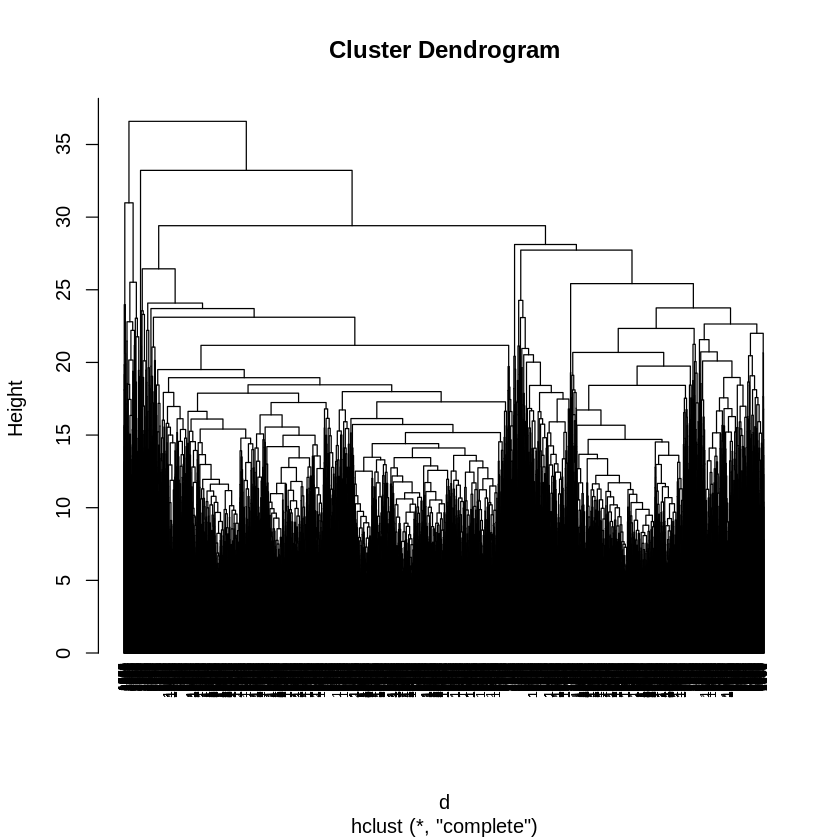

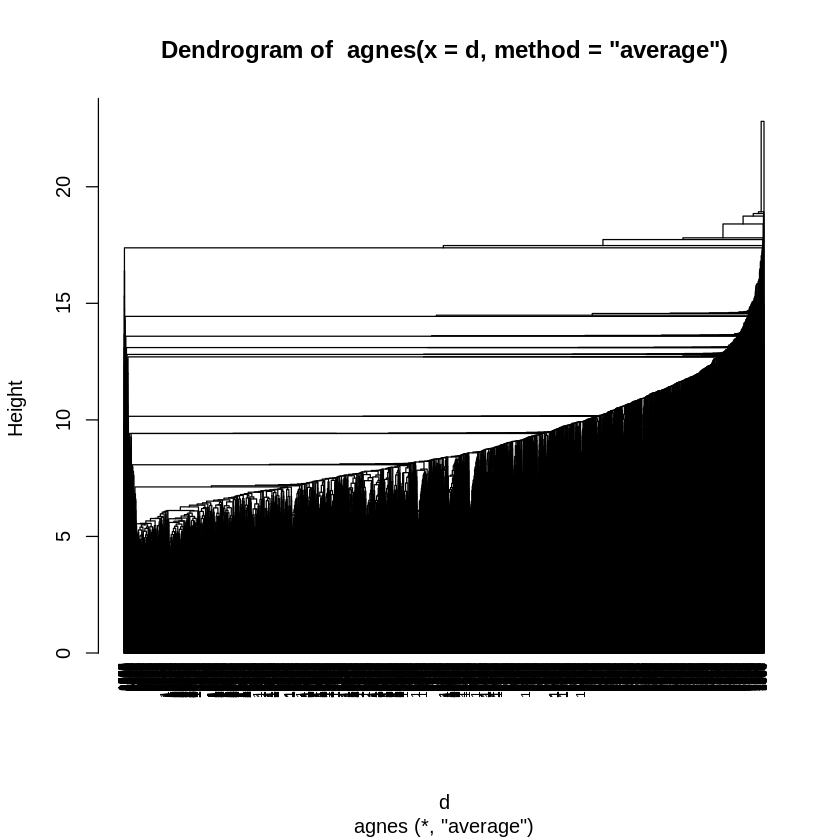

In [0]:
hc1_euclidean_complete <- hclust(d, method = "complete")
hc2_euclidean_average <- agnes(d, method = "average")

plot(hc1_euclidean_complete, cex = 0.6, hang = -1)
pltree(hc2_euclidean_average, cex = 0.6, hang = -1)

**Validación de los dendrogramas**

Para validar que el dendrograma refleja las distancias originales, podemos utilizar el *cophenetic coefficient* que es igual al coeficiente de correlación entre las distancias originales y de *cophenetic*. La función *cophenetic()* devuelve las distancias de *cophenetic* que se derivan del dendrograma. La función *cor* devuelve el coeficiente de correlación entre los valores que se pasan como argumento.

Es decir, devuelve un valor en el rango [0,1]:
* Cuanto más cercano a 0, peor es la similitud de las distancias del dendograma con las distancias reales
* Lo contrario cuando más cercano a 1, mejor y mayor es la similitud de las distancias del dendograma generado con las distancias reales

Podemos comparar los dendrogramas generados anteriormente usando los correspondientes *cophenetic coefficient*. En nuestro caso, de lejos, el mejor dendograma es el calculado con el **metodo "average"**

In [0]:
c1 <- cophenetic(hc1_euclidean_complete)
c2 <- cophenetic(hc2_euclidean_average)

cor(d, c1)
cor(d, c2)

[1] 0.327015

[1] 0.8825117

**Obteniendo clusters desde el dendrograma**

Para obtener clusters desde el dendrograma, debemos cortar este con la función *cutree()* del paquete dendextend. Debemos especificar el número de clusters que deseamos obtener, dado que nuestros datos se clasifican en 4 clases, eligiremos **k = 4**

La función *cutree()* devuelve un vector entero con el índice del cluster al que pertenece cada objeto. Podemos ver cuántos objetos pertenecen a cada cluster con la función *table()*.

In [0]:
clusters <- cutree(hc1_euclidean_complete, k = 4)
clusters
table(clusters)

clusters <- cutree(hc2_euclidean_average, k = 4)
clusters
table(clusters)

[1] 1 2 2 2 3 2 2 4 2 2 2 4 2 2 2 1 2 2 4 2 2 2 2 2 4 2 2 4 2 2 4 2 2 2 2 2
   [37] 2 2 2 2 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2
   [73] 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2
  [109] 2 2 4 2 2 2 2 4 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2
  [145] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  [181] 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 3 2 2 2 2 4 2 2 2 2 2 2 4 4 2 2 2
  [217] 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  [253] 2 2 2 2 2 3 2 2 4 2 2 2 2 2 3 2 4 2 2 2 4 2 4 3 4 2 2 2 4 2 4 2 2 2 2 2
  [289] 2 1 2 3 4 2 2 4 2 2 2 2 2 2 2 2 2 2 4 2 2 3 2 2 2 2 2 4 3 2 2 4 2 3 2 2
  [325] 2 2 2 2 2 2 4 2 4 2 4 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 4 2 2 2 2 4 4 2 2 2
  [361] 2 4 2 2 1 2 2 2 2 2 2 2 3 2 2 2 2 4 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  [397] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 4 2 2 4 2 2 2 2 2 2 2
  [433] 2 4 4 2 2 2 2 2 2 2 2 2 2 4 4 2 2 2 2 2 2 4 2 3 2 4 2 2 3 2 1 3 2 2 4 4
  [469] 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2
  [505] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 4 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2
  [541] 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2
  [577] 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  [613] 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 4 2 2 4 2 2 3 4
  [649] 2 4 2 2 2 3 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 4 2 2 2 2 2 2 4 2 2 4 2 2 2 2
  [685] 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4
  [721] 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 4 2 2 2 2 4 2 2 2 2 2 2 2 2 4 2 2 2 2
  [757] 2 2 2 4 2 1 4 3 2 2 4 2 4 2 2 4 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2
  [793] 2 2 4 4 2 4 2 2 2 4 2 2 2 4 2 2 2 2 2 2 2 2 4 4 2 2 2 3 2 2 2 2 2 2 2 2
  [829] 2 2 2 2 2 2 2 2 2 4 2 2 2 2 4 2 2 2 2 1 2 2 2 1 2 2 2 3 2 2 2 4 2 4 2 2
  [865] 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  [901] 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2
  [937] 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  [973] 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4
 [1009] 2 2 4 4 2 2 2 2 1 4 2 2 2 4 2 3 3 2 2 2 3 3 2 4 2 4 4 2 4 2 2 2 2 2 2 2
 [1045] 2 2 2 2 4 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2
 [1081] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2
 [1117] 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 4 2 2 2 2 2 2 2 2 4 2 2 2 2 4 2 2 2 2 4 2
 [1153] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2
 [1189] 2 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2
 [1225] 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1261] 2 2 2 2 2 2 2 2 4 2 2 4 2 2 4 4 2 2 2 4 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2
 [1297] 2 4 2 4 2 2 4 2 2 2 3 2 2 4 2 2 2 2 3 4 2 2 2 4 2 4 4 2 2 2 2 2 2 2 2 2
 [1333] 3 3 2 2 2 4 2 4 2 2 2 2 2 2 2 3 2 2 2 2 4 2 2 2 4 2 2 2 4 4 3 3 3 2 4 2
 [1369] 4 2 2 2 2 2 2 2 4 2 3 4 2 2 2 2 4 2 4 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1405] 2 2 2 2 4 2 2 2 4 4 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 4 2 2 2 4 2 2 2 2 2 2
 [1441] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 4
 [1477] 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1513] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1549] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1585] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1621] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1657] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1693] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1729] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1765] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 4 2 2 2
 [18

clusters
    1     2     3     4 
    9 10178    45   223 

1     2     3     4     5     6     7     8     9    10    11    12    13 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
   14    15    16    17    18    19    20    21    22    23    24    25    26 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
   27    28    29    30    31    32    33    34    35    36    37    38    39 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
   40    41    42    43    44    45    46    47    48    49    50    51    52 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
   53    54    55    56    57    58    59    60    61    62    63    64    65 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
   66    67    68    69    70    71    72    73    74    75    76    77    78 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
   79    80    81    82    83    84    85    86    87    88    89    90    91 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
   92    93    94    95    96    97    98    99   100   101   102   103   104 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  105   106   107   108   109   110   111   112   113   114   115   116   117 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  118   119   120   121   122   123   124   125   126   127   128   129   130 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  131   132   133   134   135   136   137   138   139   140   141   142   143 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  144   145   146   147   148   149   150   151   152   153   154   155   156 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  157   158   159   160   161   162   163   164   165   166   167   168   169 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  170   171   172   173   174   175   176   177   178   179   180   181   182 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  183   184   185   186   187   188   189   190   191   192   193   194   195 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  196   197   198   199   200   201   202   203   204   205   206   207   208 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  209   210   211   212   213   214   215   216   217   218   219   220   221 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  222   223   224   225   226   227   228   229   230   231   232   233   234 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  235   236   237   238   239   240   241   242   243   244   245   246   247 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  248   249   250   251   252   253   254   255   256   257   258   259   260 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  261   262   263   264   265   266   267   268   269   270   271   272   273 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  274   275   276   277   278   279   280   281   282   283   284   285   286 
    1     1     2     1     1     1     1     1     1     1     1     1     1 
  287   288   289   290   291   292   293   294   295   296   297   298   299 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  300   301   302   303   304   305   306   307   308   309   310   311   312 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  313   314   315   316   317   318   319   320   321   322   323   324   325 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  326   327   328   329   330   331   332   333   334 

clusters
    1     2     3     4 
10447     3     4     1 

Con el dendograma calculado, obtenemos que:
* Para el dendograma calculado con el metodo **complete** la mayor parte de los gestos los clasifica como clase 2 , un error del ~71%, o , lo que es lo mismo, una precisión de ~29%. 
* Para el dendograma calculado con el metodo **average** la 

Vemos que el clustering jerarquico es incapaz de clusterizar correctamente 

**Mostrando los clusters sobre el dendrograma**

Podemos mostrar los clusters sobre el dendrograma usando la función *fviz_dend* del paquete factoextra. Debemos indicar el dendrograma, el número de clusters y el valor de otros argumentos necesarios para dibujar el agrupamiento. El dendrograma puede mostrarse en horizontal, vertical o circular. Nosotros mostraremos el dendograma en circular.

In [0]:
#No ejecutar: 
#fviz_dend(as.hclust(hc2_euclidean_average), k = 4, type = "circular", k_colors = "jco", cex = 0.1)

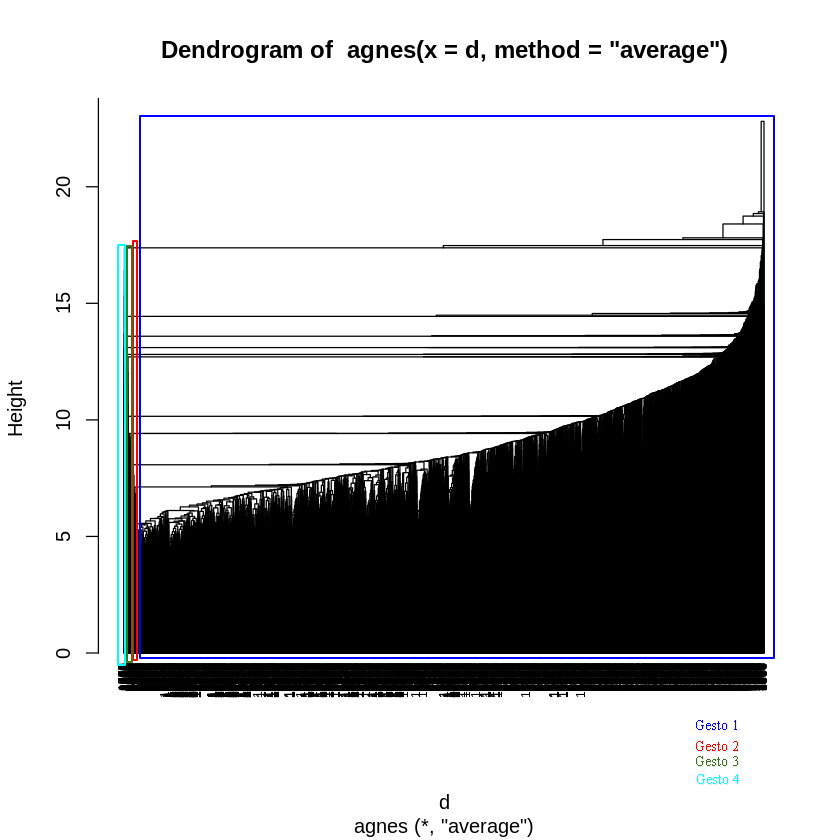

